# HEWL S-SAD Merging Statistics

Merging statistics are a useful means to assess data quality in crystallography. However, each statistic has inherent shortcomings. For example, R-merge will appear inflated if the multiplicity is high, and the Pearson correlation coefficients used for $CC_{1/2}$ are very sensitive to outliers. 

Most scaling and merging programs output multiple merging statistics to get around these shortcomings. However, one can imagine that it could also be useful to customize certain parameters, such as how many resolution bins are used. Or, perhaps a better statistic will be developed that is worth implementing. 

In this notebook, ``reciprocalspaceship`` is used to compute half dataset correlation coefficients ($CC_{1/2}$ and $CC_{anom}$) for a dataset collected from a tetragonal hen egg-white lysozyme (HEWL) crystal at 6550 eV. 
These data are unmerged, but were scaled in AIMLESS. 
They contain sufficient sulfur anomalous signal to determine a solution by the SAD method. 
This illustrates the use of ``rs`` to create a custom analysis, and could be useful as a template for other exploratory crystallographic data analyses. 
As an example, we will compare half dataset correlations computed using both Pearson and Spearman correlation coefficients.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


In [2]:
import reciprocalspaceship as rs

In [3]:
print(rs.__version__)

0.8.9


---
### Load scaled, unmerged data

In [4]:
hewl = rs.read_mtz("data/HEWL_unmerged.mtz")

In [5]:
hewl.head()

BATCH         I       SIGI  PARTIAL
H K L                                     
0 0 1    145 1.8575767 0.22305174    False
    1    865 2.2683158 0.17914094    False
    1   1231 1.4042842 0.22381113    False
    1   2145 1.6752408 0.20016733    False
    1   3231 1.2280092 0.21494065    False

In [6]:
print(f"Number of observed reflections: {len(hewl)}")

Number of observed reflections: 822299


---
### Helper functions for merging  

Since the input data are unmerged, we will implement the inverse-variance weighting scheme used by AIMLESS to merge the observations. 
The weighted average is a better estimator of the true mean than the raw average. 

The merged intensity for each reflection, $I_h$, can be determined from the observed intensities, $I_{h,i}$, and error estimates, $\sigma_{h,i}$, as follows:

\begin{equation}
I_h = \frac{\sum_{i}w_{h,i} I_{h,i}}{\sum_{i} w_{h,i}}
\end{equation}

where the weight for each observation, $w_{h,i}$ is given by:

\begin{equation}
w_{h,i} = \frac{1}{(\sigma_{h,i})^2}
\end{equation}

We will randomly split the observations into half-datasets by image number, and we will calculate:  
 - **IMEAN** : the averge intensity of both Friedel mates, $I_h$ and $I_{-h}$  
 - **I(+)** : the average intensity of $I_h$  
 - **I(-)** : the average intensity of $I_{-h}$  

for each unique Friedel pair in each half-dataset. 
We will compare these values across half-datasets in order to compute correlation coefficients by resolution bin, and we will resample the half-datasets multiple times in order to get a sense of the distribution of the correlation coefficients within each resolution bin.

In [7]:
def sample_halfdatasets(data):
    """Randomly split DataSet into two equal halves by BATCH"""
    batch = data.BATCH.unique().to_numpy(dtype=int)
    np.random.shuffle(batch)
    halfbatch1, halfbatch2 = np.array_split(batch, 2)
    half1 = data.loc[data.BATCH.isin(halfbatch1)]
    half2 = data.loc[data.BATCH.isin(halfbatch2)]
    return half1, half2

def merge(halfdataset):
    """Merge half-dataset to get IMEAN, I(+), and I(-)"""
    temp = halfdataset.copy()
    temp["invvar"] = temp.SIGI**-2
    temp["weighted"] = temp.I * temp.invvar
    tempresult = temp.groupby(["H", "K", "L", "Friedel(+)"]).agg({'weighted':'sum', 'invvar':'sum'})
    tempresult["I"] = tempresult.weighted/tempresult.invvar
    tempresult = tempresult.unstack()
    result = rs.DataSet({
        "IMEAN": (tempresult["weighted"].sum(axis=1)/tempresult["invvar"].sum(axis=1)).astype("J"),
        "I(+)": tempresult["I", True],
        "I(-)": tempresult["I", False]
    })
    return result.dropna().__finalize__(halfdataset)

Finally, here are the functions necessary to merge all of the observed reflections in the dataset:

In [8]:
def classify_friedel_pairs(data):
    """Classify whether observed reflections are Friedel(+) or Friedel(-)"""
    data.hkl_to_asu(inplace=True)
    data["Friedel(+)"] = rs.DataSeries(data["M/ISYM"]%2 == 1, dtype=bool)
    return data

def merge_dataset(mtz, nsamples):
    """
    Merge DataSet using inverse-variance weighting scheme. This represents the 
    maximum-likelihood estimatortor of the mean of the observed intensities assuming 
    they are independent and normally distributed with the same mean. 
    
    Sample means across half-datasets can be used to compute the merging statistics CC1/2 and CCanom.
    """
    mtz = mtz.copy()
    unmerged = classify_friedel_pairs(mtz)
    samples = []
    for n in range(nsamples):
        half1, half2 = sample_halfdatasets(unmerged)
        mergedhalf1 = merge(half1)
        mergedhalf2 = merge(half2)
        result = mergedhalf1.merge(mergedhalf2, left_index=True, right_index=True, suffixes=(1, 2))
        result["sample"] = n
        samples.append(result)
    return rs.concat(samples).sort_index()

---
### Merge HEWL data

We will now merge the HEWL data, repeatedly sampling across half-datasets in order to assess the distribution of correlation coefficients.

In [9]:
merged = merge_dataset(hewl, 15)

In [10]:
merged

IMEAN1     I(+)1     I(-)1    IMEAN2     I(+)2     I(-)2  sample
H  K  L                                                                    
0  0  1  1.471577 1.7099401 1.3278339 1.6083632 1.8575767 1.5566863       0
      1 1.5389882 1.8470476 1.4167432 1.4528136 1.5311382 1.4042016       1
      1 1.5583609 1.5850568   1.53037 1.4906383 1.9309214 1.3754267       2
      1 1.4440039 1.6484134 1.3593869 1.6146193  1.841894 1.4968622       3
      1 1.3491715 1.4042842 1.3407339 1.6235417 1.8026135   1.48726       4
...           ...       ...       ...       ...       ...       ...     ...
45 10 1 5.9161806 7.6295433  4.728407 6.6214385  6.951154  6.088281       9
      1  5.606877  5.717536 5.4856105  9.365798 11.071259  5.853459      10
      1 5.9571977 5.6664567 6.2042103    7.0509  8.461554 3.8962657      11
      1  4.340049  4.005453 4.5880957 7.4898357  8.209808 6.3028135      12
      1  6.758027  9.478301 4.3816113 5.9390526  4.895612  8.095466      13

[183109 rows x 7 columns]

---
### Compute $CC_{1/2}$ and $CC_{anom}$  

We will first assign each reflection to a resolution bin, and then we will compute the correlation coefficients

In [11]:
merged, labels = merged.assign_resolution_bins()

In [12]:
def cc(dataset, col1, col2, method="pearson",):
    if method == "pearson":
        cc = np.corrcoef(dataset[col1], dataset[col2])
        return cc[0, 1]
    elif method == "spearman":
        cc = stats.spearmanr(dataset[col1], dataset[col2])
        return cc.correlation

In [13]:
results_p = merged.groupby(["sample", "bin"]).apply(cc, "IMEAN1", "IMEAN2", "pearson")
results_p.name = "CC1/2"
finalp = results_p.groupby("bin").agg(["mean", "std"])

results_s = merged.groupby(["sample", "bin"]).apply(cc, "IMEAN1", "IMEAN2", "spearman")
results_s.name = "CC1/2"
finals = results_s.groupby("bin").agg(["mean", "std"])

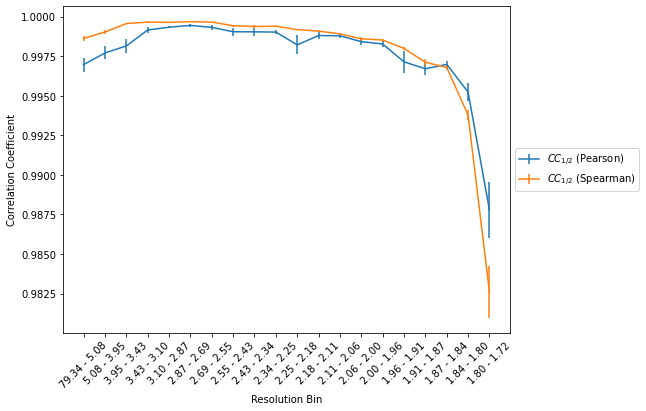

In [14]:
plt.figure(figsize=(8, 6))
plt.errorbar(finalp.index, finalp["mean"], yerr=finalp["std"], label=r"$CC_{1/2}$ (Pearson)")
plt.errorbar(finals.index, finals["mean"], yerr=finals["std"], label=r"$CC_{1/2}$ (Spearman)")

plt.xticks(finalp.index, labels, rotation=45)
plt.ylabel(r"Correlation Coefficient")
plt.xlabel("Resolution Bin")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

It is important to note the scale on the y-axis -- this dataset is edge-limited, and as such the $CC_{1/2}$ is very high across all resolution bins. The Spearman CC appears higher across all resolution bins except at high resolution, and overall has a lower standard deviation among samples.
This is consistent with our expectation that Spearman CCs are a more robust estimator of correlation than Pearson CCs.

The following cell repeats this procedure for the anomalous correlations. 

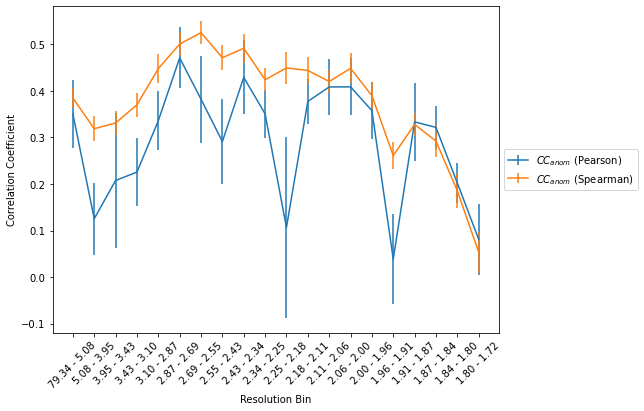

In [15]:
merged["ANOM1"] = merged["I(+)1"] - merged["I(-)1"]
merged["ANOM2"] = merged["I(+)2"] - merged["I(-)2"]

results_pa = merged.groupby(["sample", "bin"]).apply(cc, "ANOM1", "ANOM2", "pearson")
results_pa.name = "CC1/2"
finalpa = results_pa.groupby("bin").agg(["mean", "std"])

results_sa = merged.groupby(["sample", "bin"]).apply(cc, "ANOM1", "ANOM2", "spearman")
results_sa.name = "CC1/2"
finalsa = results_sa.groupby("bin").agg(["mean", "std"])


plt.figure(figsize=(8, 6))
plt.errorbar(finalpa.index, finalpa["mean"], yerr=finalpa["std"], label=r"$CC_{anom}$ (Pearson)")
plt.errorbar(finalsa.index, finalsa["mean"], yerr=finalsa["std"], label=r"$CC_{anom}$ (Spearman)")

plt.xticks(finalpa.index, labels, rotation=45)
plt.ylabel(r"Correlation Coefficient")
plt.xlabel("Resolution Bin")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

There is significant anomalous signal across all but the highest resolution bin. The comparison between Pearson and Spearman correlation coefficients shows that the Pearson CC is greatly influenced by outliers in the $2.25Å-2.18Å$ and $2.00Å-1.96Å$ resolution bins.